<h1 style="text-align: center;">hybraut watchdog</h1>

The runtime system is monitored and managed by a **hybraut-executor-watchdog (FSM)**. This FSM listens to runtime events and responds accordingly to maintain mission continuity and enable it to automate part of the **hybraut_ros2** lifecycle, enable it to recover from failures, and safely shut down in critical conditions. It helps enforce lifecycle safety and determinism across automaton operations.

When specific events are published (e.g., mode transitions, errors, mission completion), the FSM interprets these and updates the automaton's state. Each FSM state is also associated with a corresponding **status message**, which is published to inform external systems about the automaton's condition.

![hybraut_watchdog_fsm_png](../.github/diagrams/hybraut_watchdog_fsm_flowchart.png)

## Setup

The code below is a simple setup of a mock node containing the **hybraut-exeuctor-watchdog (FSM)** I/O ros2 publishers and subscriptions that are required for the automaton to transition and output statuses associated with **FSM** states

In [78]:
import rclpy
from rclpy.node import Node
from rclpy.qos import QoSProfile, qos_profile_system_default
import os
import threading
import time
from rclpy.executors import MultiThreadedExecutor, Executor
from rclpy.callback_groups import ReentrantCallbackGroup
from hybraut_executor_watchdog import FSM
from hybraut_interfaces.msg import AutomatonEvents, AutomatonStatus
from hybraut_executor_watchdog.hybraut_consts import EventEnum, StatusEnum

if rclpy.ok():
    rclpy.shutdown()


rclpy.init()


QOS = QoSProfile(depth=10, reliability=qos_profile_system_default.reliability)

try:
    executor: Executor = MultiThreadedExecutor(num_threads=os.cpu_count())
    node = Node("hybraut_watchdog_demo")
    executor.add_node(node)
    
    # Start executor in background thread
    thread = threading.Thread(target=executor.spin, daemon=True)
    thread.start()
    
    # Create FSM instance
    fsm = FSM(node=node, cb_group=ReentrantCallbackGroup(), qos=QOS)
    
    # Create event publisher for testing
    event_publisher = node.create_publisher(
        AutomatonEvents, "/automaton/events", 
        qos_profile=QOS, callback_group=ReentrantCallbackGroup()
    )

    current_statuses = [fsm.get_current_state().value]

    def status_callback(msg: AutomatonStatus):
        current_statuses.append(msg.type)
        
    status_subscription = node.create_subscription(
        AutomatonStatus, "/automaton/status",
        status_callback, qos_profile=QOS, callback_group=ReentrantCallbackGroup()
    )
    
    # Wait for connections
    time.sleep(1.0)
except Exception as e:
    rclpy.shutdown()
    exit(1)

below is a function for running through test event list and verifying the tests executed correctly

In [79]:
from typing import List, Tuple
import time
from hybraut_interfaces.msg import AutomatonEvents, AutomatonStatus

def execute_test_events(
    test_events: List[Tuple[EventEnum, str]],
) -> None:
    """
    Execute a series of test events on the FSM and return the results.

    Returns:
        A list of tuples, each containing:
        - The AutomatonEvent that was published
        - The actual FSM state and message after the event
        - The expected FSM state and message
    """

    for event_type, message in test_events:
        # Publish event
        event_msg = AutomatonEvents(type=event_type.value, message=message)
        event_publisher.publish(event_msg)

        # Allow FSM time to process
        time.sleep(0.2)

## Basic Happy Path Test

This test tests a valid test. 
Active -> TRANSITIONING -> ACTIVE -> MISSION_COMPLETE

In [ ]:
test_events = [
    (EventEnum.TRANSITION_GUARD_ENABLED, "mode guard activated"),
    (EventEnum.TRANSITION_COMPLETE, "transition completed"),
    (EventEnum.TRANSITION_GUARD_ENABLED, "mode guard activated"),
    (EventEnum.TRANSITION_COMPLETE, "transition completed"),
    (EventEnum.TRANSITION_GUARD_ENABLED, "mode guard activated"),
    (EventEnum.TRANSITION_COMPLETE, "transition completed"),
    (EventEnum.TRANSITION_GUARD_ENABLED, "mode guard activated"),
    (EventEnum.TRANSITION_COMPLETE, "transition completed"),
    (EventEnum.TRANSITION_GUARD_ENABLED, "mode guard activated"),
    (EventEnum.TRANSITION_COMPLETE, "transition completed"),
    (EventEnum.MISSION_COMPLETE, "mission has completed"),
]


expected_status = [
    (StatusEnum.ACTIVE, ""),
    (StatusEnum.TRANSITIONING, ""),
    (StatusEnum.ACTIVE, ""),
    (StatusEnum.TRANSITIONING, ""),
    (StatusEnum.ACTIVE, ""),
    (StatusEnum.TRANSITIONING, ""),
    (StatusEnum.ACTIVE, ""),
    (StatusEnum.TRANSITIONING, ""),
    (StatusEnum.ACTIVE, ""),
    (StatusEnum.MISSION_COMPLETE, "")
]

execute_test_events(test_events)

[INFO] [1754643107.513422289] [hybraut_watchdog_demo]: Processing event: EventEnum.TRANSITION_GUARD_ENABLED
[INFO] [1754643107.514878390] [hybraut_watchdog_demo]: Fired trigger: enable_guard
[INFO] [1754643107.661618124] [hybraut_watchdog_demo]: Processing event: EventEnum.TRANSITION_COMPLETE
[INFO] [1754643107.662231024] [hybraut_watchdog_demo]: Fired trigger: complete_transition
[INFO] [1754643107.860161470] [hybraut_watchdog_demo]: Processing event: EventEnum.TRANSITION_GUARD_ENABLED
[INFO] [1754643107.861692170] [hybraut_watchdog_demo]: Fired trigger: enable_guard
[INFO] [1754643108.064677817] [hybraut_watchdog_demo]: Processing event: EventEnum.TRANSITION_COMPLETE
[INFO] [1754643108.065487217] [hybraut_watchdog_demo]: Fired trigger: complete_transition
[INFO] [1754643108.330893879] [hybraut_watchdog_demo]: Processing event: EventEnum.TRANSITION_GUARD_ENABLED
[INFO] [1754643108.331740079] [hybraut_watchdog_demo]: Fired trigger: enable_guard
[INFO] [1754643108.474378112] [hybraut_wa

this is the display of the results for the first test

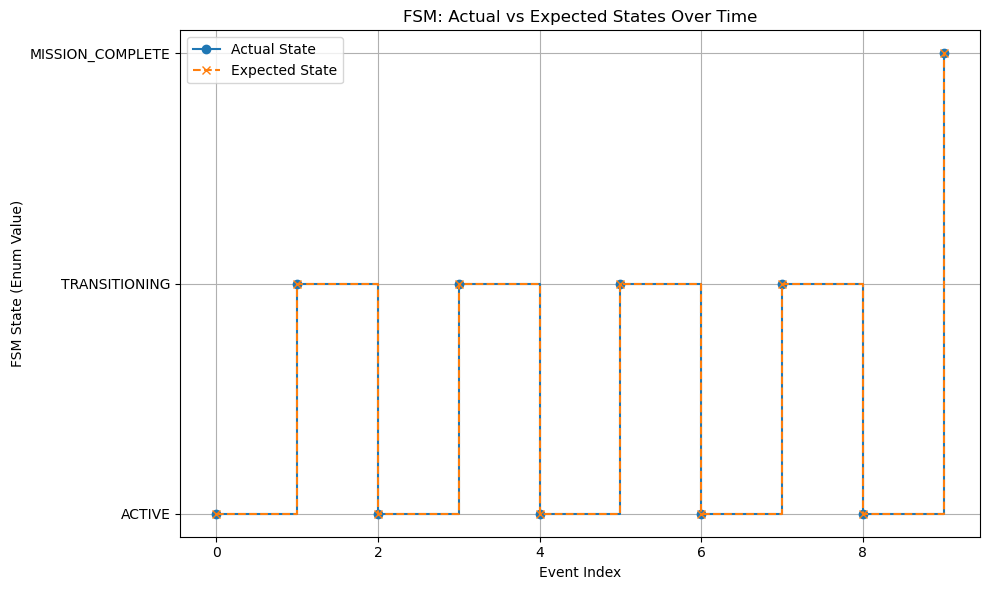

In [66]:
import matplotlib.pyplot as plt

# Data
actual_states = [StatusEnum(actual).name for actual in current_statuses]
expected_states = [StatusEnum(expected[0].value).name for expected in expected_status]
time_steps = list(range(len(actual_states)))

# Plot
plt.figure(figsize=(10, 6))
plt.step(time_steps, actual_states, label='Actual State', where='post', marker='o')
plt.step(time_steps, expected_states, label='Expected State', linestyle='--', where='post', marker='x')

# Axis labels
plt.xlabel('Event Index')
plt.ylabel('FSM State (Enum Value)')
plt.title('FSM: Actual vs Expected States Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Error Handling Tests: 

### Recoverable Error Path
 ON_VALID_MISSION_REQUEST -> ACTIVE -> RECOVERABLE_ERROR -> ERROR -> RECOVERING -> RECOVERED -> ACTIVE -> MISSION_COMPLETE -> MISSION_COMPLETE

In [80]:
current_statuses = [StatusEnum.ACTIVE.value]

test_events = [
    (EventEnum.RECOVERABLE_ERROR, "mode guard activated"),
    (EventEnum.RECOVERED, "recovery completed"),
    (EventEnum.MISSION_COMPLETE, "mission has completed")
]


expected_status = [
    (StatusEnum.ACTIVE, ""),
    (StatusEnum.ERROR, ""),
    (StatusEnum.RECOVERING, ""),
    (StatusEnum.ACTIVE, ""),
    (StatusEnum.MISSION_COMPLETE, ""),
]

execute_test_events(test_events)

[INFO] [1754643874.174572376] [hybraut_watchdog_demo]: Processing event: EventEnum.RECOVERABLE_ERROR
[WARN] [1754643874.177621455] [hybraut_watchdog_demo]: Entered ERROR state
[INFO] [1754643874.190272180] [hybraut_watchdog_demo]: Published status: StatusEnum.ERROR
[INFO] [1754643874.192684986] [hybraut_watchdog_demo]: Status received: hybraut_interfaces.msg.AutomatonStatus(type=5, message='State changed to StatusEnum.ERROR', stamp=builtin_interfaces.msg.Time(sec=1754643874, nanosec=178233186))
[INFO] [1754643874.194184087] [hybraut_watchdog_demo]: Fired trigger: handle_recoverable_error
[INFO] [1754643874.361328066] [hybraut_watchdog_demo]: Processing event: EventEnum.RECOVERED
[INFO] [1754643874.363210247] [hybraut_watchdog_demo]: Fired trigger: complete_recovery
[INFO] [1754643874.564843415] [hybraut_watchdog_demo]: Processing event: EventEnum.MISSION_COMPLETE
[INFO] [1754643874.566749439] [hybraut_watchdog_demo]: Fired trigger: finish_mission


RESULTS: 

['ACTIVE', 'ERROR']
['ACTIVE', 'ERROR', 'RECOVERING', 'ACTIVE', 'MISSION_COMPLETE']


ValueError: x and y must have same first dimension, but have shapes (2,) and (5,)

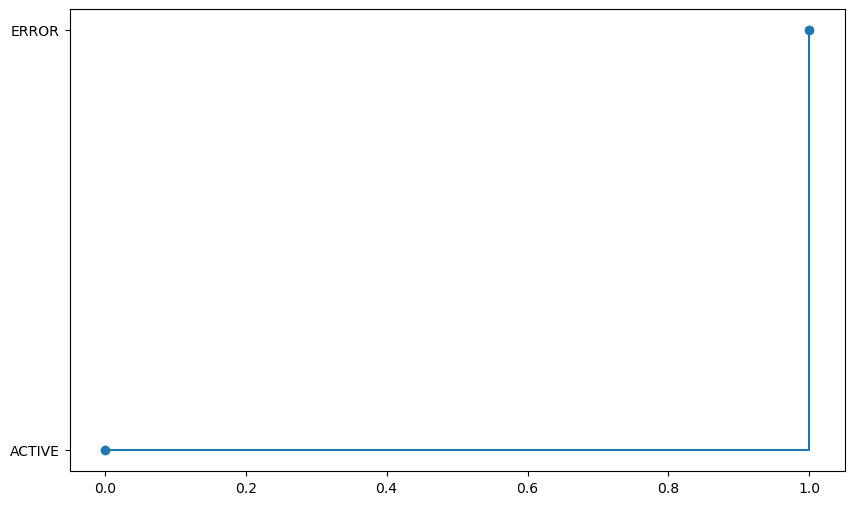

In [77]:
import matplotlib.pyplot as plt

# Data
actual_states = [StatusEnum(actual).name for actual in current_statuses]
expected_states = [StatusEnum(expected[0].value).name for expected in expected_status]
time_steps = list(range(len(actual_states)))

# Plot
plt.figure(figsize=(10, 6))

print (actual_states)
print (expected_states)

plt.step(time_steps, actual_states, label='Actual State', where='post', marker='o')
plt.step(time_steps, expected_states, label='Expected State', linestyle='--', where='post', marker='x')

# Axis labels
plt.xlabel('Event Index')
plt.ylabel('FSM State (Enum Value)')
plt.title('FSM: Actual vs Expected States Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Critical Failure Path
ON_VALID_MISSION_REQUEST → ACTIVE
RECOVERABLE_ERROR → ERROR
CRITICAL_FAILURE → FATAL
SHUTDOWN → (terminal state)

Recovery Failure Path:

ON_VALID_MISSION_REQUEST → ACTIVE
RECOVERABLE_ERROR → ERROR
ATTEMPT_FIX → RECOVERING
RECOVERY_FAILED → FATAL
SHUTDOWN → (terminal state)

#### Error From Transitioning
ON_VALID_MISSION_REQUEST → ACTIVE
TRANSITION_GUARD_ENABLED → TRANSITIONING
RECOVERABLE_ERROR → ERROR
ATTEMPT_FIX → RECOVERING
RECOVERED → ACTIVE

In [6]:
if rclpy.ok():
    rclpy.shutdown()